# **Displacement and Housing Burden in Los Angeles County**
## *By Bryzen Morales, Elizabeth Shin, Gina Ranieri, and Leo Blain*

The recent Los Angeles wildfires have displaced thousands of people, creating a sudden surge in demand for long-term rental housing–just as supply has drastically shrunk. According to [Strategic Actions for a Just Economy](https://inthesetimes.com/article/price-gouging-wildfires-los-angeles-landlords), many landlords have taken advantage of this crisis by illegally inflating rental prices across the city. While some displaced residents—such as wealthy homeowners from Pacific Palisades—may be able to absorb these costs, many others cannot.

**Rental price gouging will disproportionately harm economically and demographically vulnerable populations, further deepening inequalities across Los Angeles County. In this project, we seek to identify the communities or neighboroods who are most vulnerable to rental price gouging. This vulnerability, we think, is a contributor to both housing burden and displacement across the Los Angeles County.**

Disclaimer: most of the codes included here came from the class' general GitHub repo. Some modifications have been included and I have linked them

# 1 | Analytical Framework

In order to understand neighborhood "vulnerability," we use a current, existing index, like the housing burden index from the [California Environmental Justice Alliance (CEJA) CalEnviroScreen tool](https://oehha.ca.gov/calenviroscreen/indicator/housing-burden). This data is available at the Census tract level, which will serve as a proxy for neighborhoods. The purpose of examining this vulnerability is to know, prior to the Los Angeles wildfires, which neighborhoods are going to be negatively impacted by rental price gouging (as a result of climate disasters like the wildfires). 

Additionally, the current housing burden index defines housing burden as the fraction of **low-income** households in a census tract that spend **more than half** of their income on housing. We, however, theorize that other characteristics, like race, age, housing units, etc. within a neighborhood, contributes to whether a neighborhood has a high/low housing burden. We will extract these attributes from the 2015-2019 5-year American Community Survey (ACS) estimates. For our purpose, we hope to  reveal the relationship (*or the connection*) between these demographic and socioeconomic characteristics with the housing burden index, to create a unified index by the final assignment.

# 2 | Part 1: Data Extraction and Preparation

Though we have Social Explorer and the US Census website as a tool t, we are going to try to use an API to ease our process. The documentation source for these codes comes from [PyGIS]("https://pygis.io/docs/d_access_census.html") and this formal [census documentation]("https://pypi.org/project/census/'). We will call every variable by referencing this [data dictionary documentation]("https://www.census.gov/programs-surveys/acs/technical-documentation/table-shells.2019.html#list-tab-79594641") of the ACS 2015-2019 estimates. Now, let's import the modules
and call all of our variables.

In [1]:
## importing necessary modules ##

# for graphing
import matplotlib.pyplot as plt

# for (sophisticated) graphing
import plotly.express as px

# for more graphing tools
import seaborn as sns

# for data wrangling
import pandas as pd

# for more data wrangling
import numpy as np

# for handling spatial data
import geopandas as gpd

# for using API from Census

! pip install Census
! pip install us

from census import Census
from us import states

# for basemaps

import contextily as ctx

In [2]:
# calling Census using API key (obtained by: Bryzen)

c = Census("ef95485bd9d6c9a56f245ed4f2cc2ad96fe5eb1f")

In [3]:
# importing ACS data 

ca_census = c.acs5.state_county_tract(
    fields = ('NAME', 
              'B01003_001M', # total population
              'B02001_002E', # white alone 
              'B02001_003E', # black alone
              'B02001_004E', # american indian alone
              'B02001_005E', # asian alone
              'B03002_012E', # hispanic or latino
              'B03002_002E', # non-hispanic or latino,
              'B09020_001E', # population, age: 65+
              'B03002_003E', # non-hispanic white
              'B25034_001E', # total housing units
              'B25034_008E', # built 1960-1969
              'B25034_009E', # built 1950-1959
              'B25034_010E', # built 1940-1949
              'B25034_011E', # built 1939 or earlier
              'B25004_001E', # vacant housing units
              'B25004_002E', # for rent housing units
              'B25004_004E', # for sale housing units
              'B25004_008E', # other vacant housing units
              'B25058_001E', # median contract rent
              'B25105_001E', # median monthly housing costs
              'B25106_024E', # renter-occupied housing units
              'B25106_028E', # for income bracket, 20,000, allocates 30% or more housing costs
              'B25106_032E', # for income bracket, 20k to 34k, allocates 30% or more housing costs
              'B25106_036E', # for income bracket, 35k to 49k, allocates 30% or more housing costs
              'B25106_040E' # for income bracket, 50k to 74k, allocates 30% or more housing costs
              ),
    state_fips = states.CA.fips,
    county_fips = "*",
    tract = "*",
    year = 2019)

In [4]:
# converting into a pandas data frame

ca_census_df = pd.DataFrame(ca_census)

In [5]:
# inspecting the data frame's properties

ca_census_df.head(1)

,NAME,B01003_001M,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B03002_012E,B03002_002E,B09020_001E,B03002_003E,...,B25058_001E,B25105_001E,B25106_024E,B25106_028E,B25106_032E,B25106_036E,B25106_040E,state,county,tract
0,"Census Tract 5079.04, Santa Clara County, Cali...",147.0,892.0,0.0,63.0,2097.0,105.0,3090.0,528.0,853.0,...,2899.0,3244.0,115.0,0.0,9.0,0.0,0.0,06,085,507904


In [6]:
# creating a string to create a FIPS column 

ca_census_df["GEOID"] = ca_census_df["state"] + ca_census_df["county"] + ca_census_df["tract"]

ca_census_df.tail(1)

,NAME,B01003_001M,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B03002_012E,B03002_002E,B09020_001E,B03002_003E,...,B25105_001E,B25106_024E,B25106_028E,B25106_032E,B25106_036E,B25106_040E,state,county,tract,GEOID
8056,"Census Tract 1044.04, Los Angeles County, Cali...",330.0,1845.0,62.0,15.0,67.0,2867.0,217.0,259.0,80.0,...,1469.0,369.0,64.0,62.0,51.0,36.0,06,037,104404,06037104404


# 3 | Part 2: More Data Cleaning, Subsetting and Merging

**Our variables are very confusing!** There is so many of them, let's rename every variable! Also, let us subset the data to only include the county of LA and merge this with the CalEnviroScreen dataset.

In [7]:
# subsetting the data to only include the state to be in LA

tracts_v2 = ca_census_df[ca_census_df['county']=='037']

In [8]:
# importing CalEnviroScreen 4.0 Housing Burden data

index = gpd.read_file("/home/jovyan/UP221-bryzen/data/index_shp/index.shp")

In [9]:
# merge datasets together

la = pd.merge(index, 
              tracts_v2,
              left_on = 'Geo_FIPS',
              right_on = 'GEOID')

In [10]:
# converting to geodata frame and specifying the "geometry" column as the "index"

la_gpd_df = gpd.GeoDataFrame(data=la, geometry=la['geometry']).to_crs(4326)

In [11]:
# renaming the column names

la_gpd_df = la_gpd_df.rename(
    columns={
              'B01003_001M' : 'total_pop',
              'B02001_002E' : 'white_pop', 
              'B02001_003E' : 'black_pop',
              'B02001_004E' : 'american_indian_pop',
              'B02001_005E' : 'asian_pop',
              'B03002_012E' : 'hispanic',
              'B03002_002E' : 'non-hispanic',
              'B09020_001E' : '65+_age',
              'B03002_003E' : 'non_hispanic_white',
              'B25034_001E' : 'total_housing',
              'B25034_008E' : 'housing_1960_1969',
              'B25034_009E' : 'housing_1950_1959',
              'B25034_010E' : 'housing_1940_1949',
              'B25034_011E' : 'housing_1939_earlier',
              'B25004_001E' : 'vacant_housing_units',
              'B25004_002E' : 'rent_housing_units',
              'B25004_004E' : 'sale_housing_units',
              'B25004_008E' : 'other_vacant_housing units',
              'B25058_001E' : 'median_contract_rent',
              'B25105_001E' : 'median_monthly_housing_costs',
              'B25106_024E' : 'renter_occupied_housing_units',
              'B25106_028E' : 'less_than_20k',
              'B25106_032E' : '20k_to_34k',
              'B25106_036E' : '35k_to_49k',
              'B25106_040E' : '50k_to_74k'
    })

In [12]:
# Whew... too many variables!! Let's make sure
# all the variables are included though.

la_gpd_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Geo_FIPS                       2342 non-null   object  
 1   Census Tra                     2342 non-null   object  
 2   Median Con                     2288 non-null   float64 
 3   Median Mon                     2309 non-null   float64 
 4   Total Rent                     2342 non-null   int64   
 5   less than                      2342 non-null   int64   
 6   20,000 to                      2342 non-null   int64   
 7   35,000 To                      2342 non-null   int64   
 8   50,000 To                      2342 non-null   int64   
 9   less tha_1                     2315 non-null   float64 
 10  20,000 t_1                     2315 non-null   float64 
 11  35,000 T_1                     2315 non-null   float64 
 12  50,000 T_1                

# 4 | Part 1: Data Visualization, Housing Burden Index

Part of good data visualization is to find the appropriate graphs/bars/charts. Because we are looking at Housing Burden, it may be a good idea to find the statistical and spatial distribution of housing burden across the Los Angeles County.

In [13]:
# creating a histogram 

fig = px.histogram(la_gpd_df, 
                   x = "Housing Bu", 
                   nbins = 20,
                   title = 'Distribution of Housing Burden Score Across LA County',
                   labels = {
                       'Housing Bu' : 'Housing Burden Index',
                       'count' : 'Count of LA Neighborhoods'},
                  color_discrete_sequence=['red'])

In [14]:
# statistical properties

# find median 
median = la_gpd_df['Housing Bu'].median()
print('Median Housing Burden Score Across LA County:', median)

# find mean

mean = la_gpd_df['Housing Bu'].mean()
print('Average Housing Burden Score Across LA County:', mean)

Median Housing Burden Score Across LA County: 21.75
Average Housing Burden Score Across LA County: 22.499474145486413


The mean Housing Burden Index is higher than the median, meaning the distribution of housing burden across Los Angeles is skewed to the right. This can also be seen in the bar chart, with outliers located on the higher end of the index. Let's see the spatial distribution of this housing burden score alongside this graph.

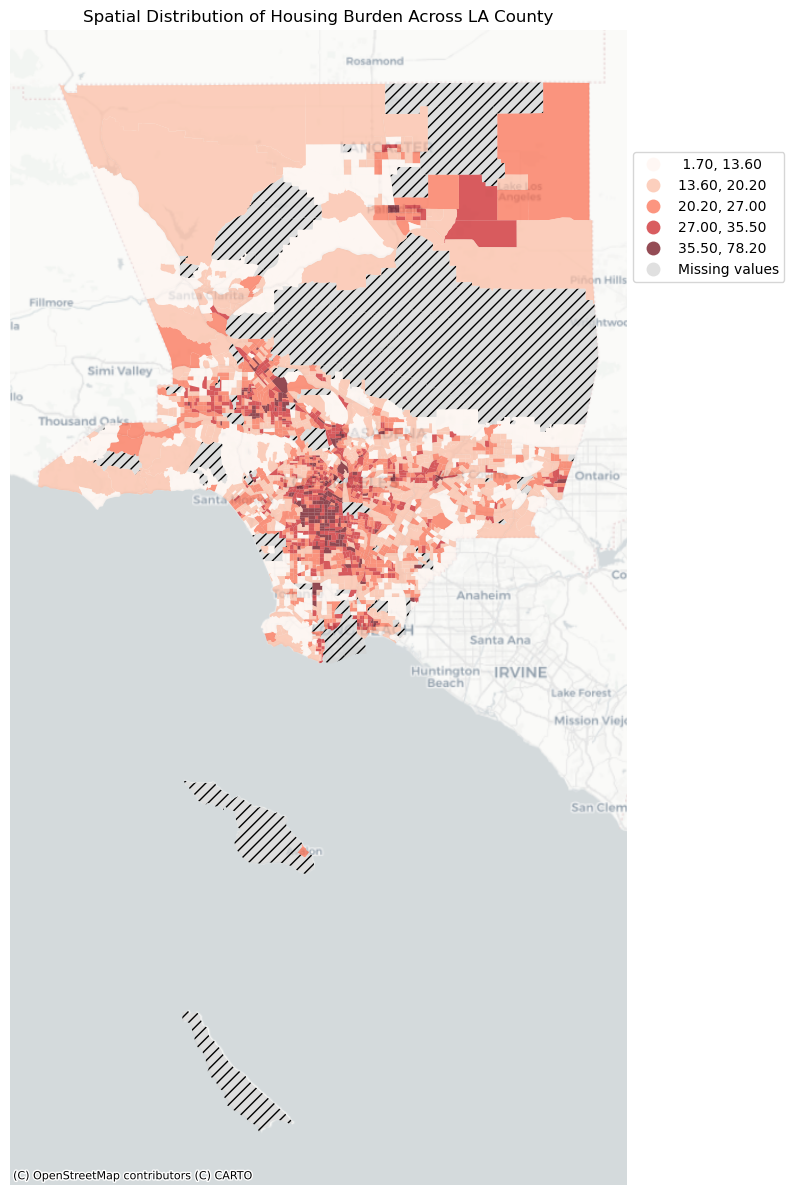

In [15]:
# creating the map
fig, ax = plt.subplots(figsize = (15,15))

# creating a map
la_gpd_df.plot(
    ax = ax,
    column = 'Housing Bu',
    scheme = "naturalbreaks",
    k = 5, 
    alpha = 0.7,
    legend = True,
    cmap = 'Reds',
    missing_kwds={
        "color": "lightgrey",
        "hatch": "///",
        "label": "Missing values"},
    legend_kwds={
        'loc':'upper left',
        'bbox_to_anchor':(1,.9)}
)
ax.set_title("Spatial Distribution of Housing Burden Across LA County")

# setting the axis off

ax.axis('off')

#adding a basemap

ctx.add_basemap(ax=ax,
                source=ctx.providers.CartoDB.Positron,
                alpha=1.0, # add transparency to make it less dominant
                crs=4326)

The spatial distribution of housing burden index across LA reveals more insights, the highest housing burden index tend to also cluster around area (around Downtown, LA).

# 5 | Part 2: Data Visualization, Too Expensive? Income, Housing Costs Allocation

Per the definition of housing burden index, neighborhoods or Census tracts that have high housing burden are low-income and who allocates 50% of their allowance towards housing costs. 

Let's investigate this further by considering other income brackets. What is the relationship of income and housing burden within vulnerable neighborhoods? We could make side-by-side regression line fits, gainst each income bracket, where we control for one of the factors of being housing burdened: allocating 30% of a household allowance towards housing costs.

[Reference Code: Seaborn]("https://python-graph-gallery.com/42-custom-linear-regression-fit-seaborn/")

In [16]:
# calculating proportion; let's focus on the lowest and highest income bracket

la_gpd_df["less_than_20k_prop"] = la_gpd_df["less_than_20k"] / la_gpd_df["renter_occupied_housing_units"]
la_gpd_df["50k_to_74k_prop"] = la_gpd_df["50k_to_74k"] / la_gpd_df["renter_occupied_housing_units"]

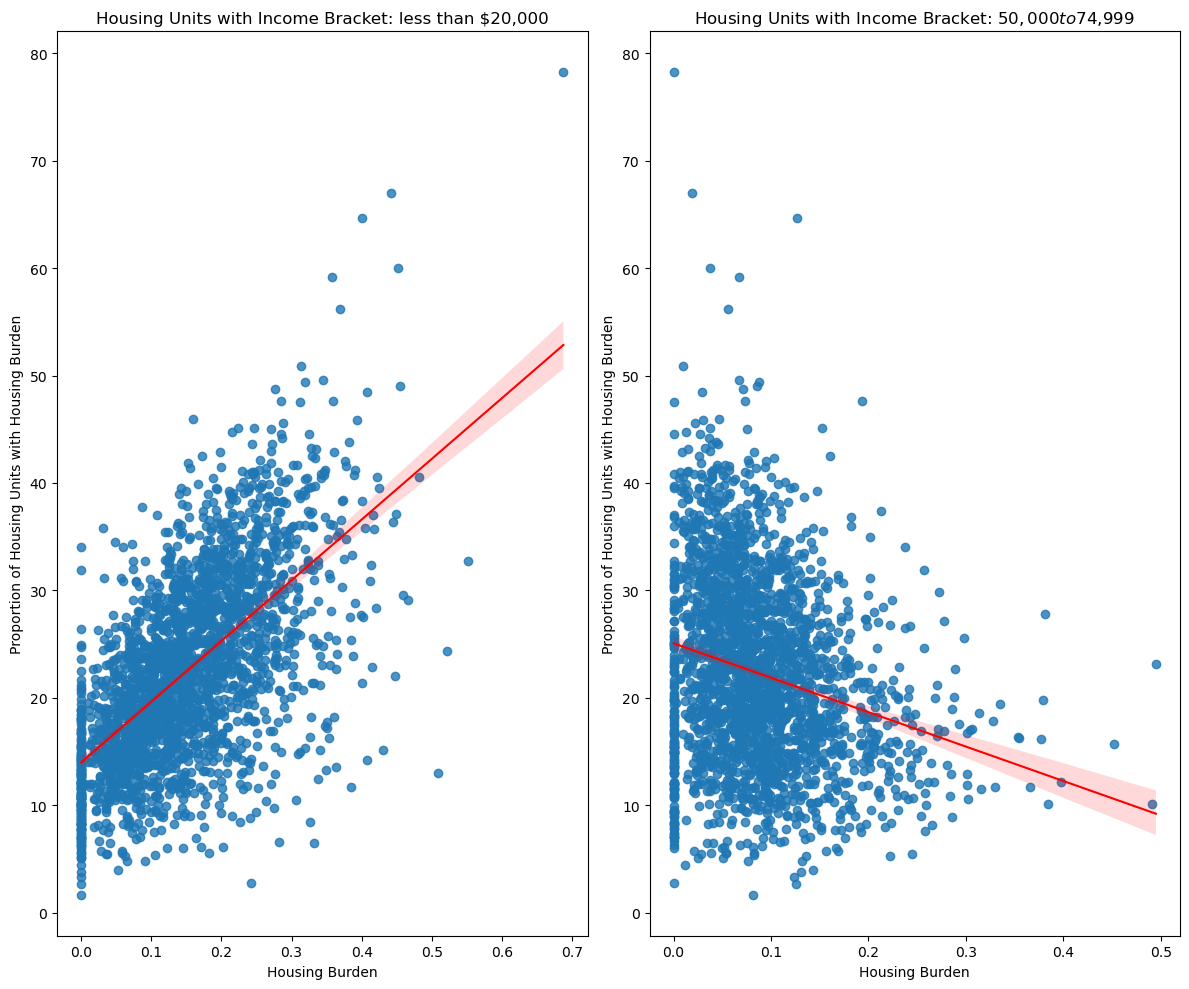

In [64]:
# creating side-by-side plots

fig, ax = plt.subplots(1,2,figsize=(12, 10))
sns.regplot(
    ax=ax[0],
    y=la_gpd_df["Housing Bu"],
    x=la_gpd_df["less_than_20k_prop"],
    line_kws={"color": "red", "linewidth": 1.5},
    
)
ax[0].set_title("Housing Units with Income Bracket: less than $20,000")
ax[0].set(xlabel='Housing Burden', ylabel='Proportion of Housing Units with Housing Burden')

sns.regplot(
    ax=ax[1],
    y=la_gpd_df["Housing Bu"],
    x=la_gpd_df["50k_to_74k_prop"],
    line_kws={"color": "red", 
              "linewidth": 1.5},
    robust = True
)
ax[1].set_title("Housing Units with Income Bracket: $50,000 to $74,999")
ax[1].set(xlabel='Housing Burden', ylabel='Proportion of Housing Units with Housing Burden')

plt.tight_layout()
plt.show()

Wow! Again, we see that income definitely plays a role with housing burden. The positive relationship we see is pretty much consistent with how the index was created. What is new is that we see a shift of this relationship if we consider a higher income bracket. 

# 6 | Part 3: Data Visualization, Race, Space, and Housing Burden

Now, it may be interesting to look at how housing burden correlated to the population of people of color. As concepts and theories in urban planning called [place stratification]("https://pmc.ncbi.nlm.nih.gov/articles/PMC3359053/#:~:text=Place%20stratification%20theory%20describes%20how,%3B%20Logan%20and%20Molotch%201987), this is an important step to understand  what are the characteristics of these neighborhoods that has high housing burden. Specifically, how are the racial characteristics of these neighborhood related to housing burden?

For this example, let's calculate the percent of people of color and the percent of non-hispanic White. While each racial/ethnic groups have varied experiences (which is an important thing to consider), for this analysis, using these percentages can give us enough insights.

In [57]:
## calculating key statistics

# calculating percent of people of color
la_gpd_df['percent_poc'] = ((la_gpd_df['hispanic'] + la_gpd_df['non-hispanic'] - la_gpd_df['non_hispanic_white']) / (la_gpd_df['hispanic'] + la_gpd_df['non-hispanic'])) * 100

# calculating percent of white
la_gpd_df['percent_white'] = la_gpd_df['non_hispanic_white']/ (la_gpd_df['hispanic'] + la_gpd_df['non-hispanic']) * 100

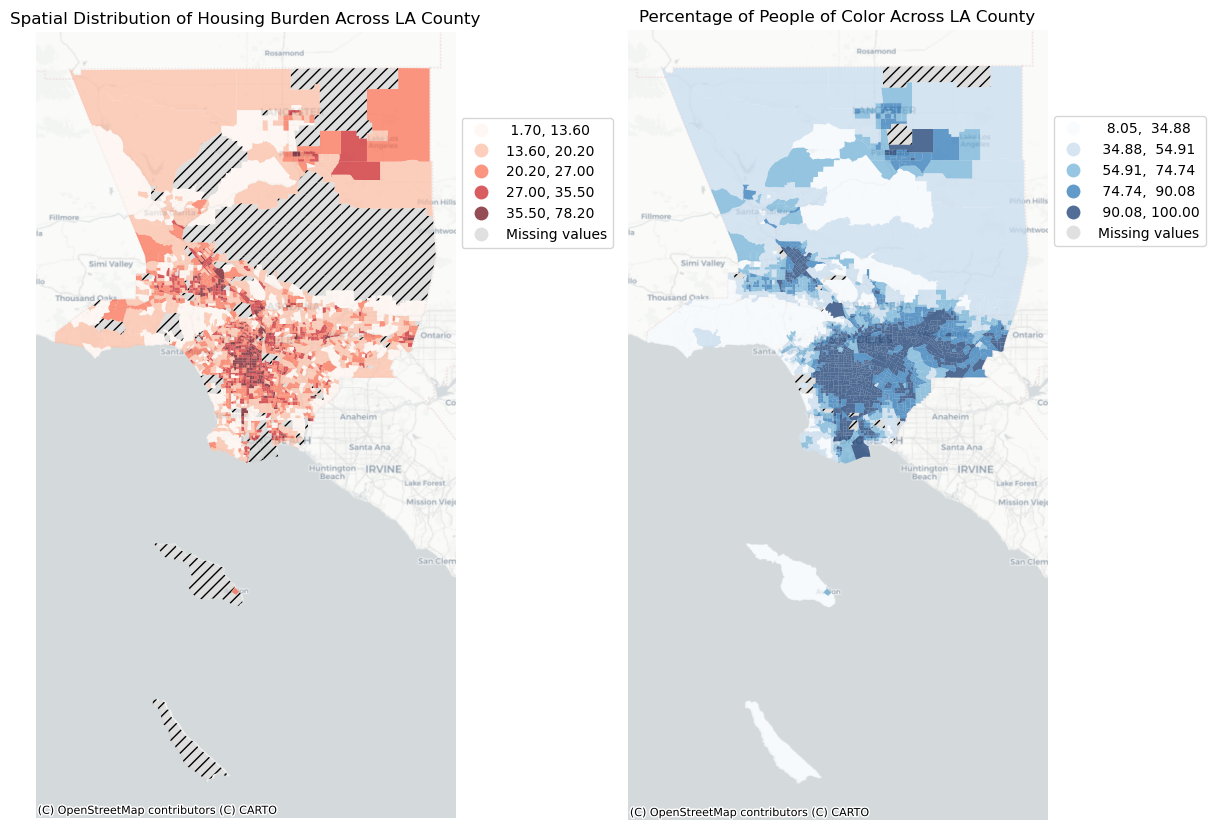

In [49]:
## creating the maps
fig, ax = plt.subplots(1, 2, figsize = (12,12))

# creating a map for the housing burden

la_gpd_df.plot(
    ax = ax[0],
    column = 'Housing Bu',
    scheme = "naturalbreaks",
    k = 5, 
    alpha = 0.7,
    legend = True,
    cmap = 'Reds',
    missing_kwds={
        "color": "lightgrey",
        "hatch": "///",
        "label": "Missing values"},
    legend_kwds={
        'loc':'upper left',
        'bbox_to_anchor':(1,.9)}
)
ax[0].set_title("Spatial Distribution of Housing Burden Across LA County")

# setting the axis off

ax[0].axis('off')

ctx.add_basemap(ax=ax[0],
                source=ctx.providers.CartoDB.Positron,
                alpha=1.0, # add transparency to make it less dominant
                crs=4326)

# creating a map for the percent of poc
10
la_gpd_df.plot(
    ax = ax[1],
    column = 'percent_poc',
    scheme = "naturalbreaks",
    k = 5, 
    alpha = 0.7,
    legend = True,
    cmap = 'Blues',
    missing_kwds={
        "color": "lightgrey",
        "hatch": "///",
        "label": "Missing values"},
    legend_kwds={
        'loc':'upper left',
        'bbox_to_anchor':(1,.9)}
)
ax[1].set_title("Percentage of People of Color Across LA County")
ax[1].axis('off')
ctx.add_basemap(ax=ax[1],
                source=ctx.providers.CartoDB.Positron,
                alpha=1.0, # add transparency to make it less dominant
                crs=4326)

plt.tight_layout()
plt.show()

Wow! These two maps clearly shows the strong relationship between housing burden and race. While we do not always want to produce trendlines (because they have so many assumptions that masks relationships), mapping these two variables side by side communicates the relationship well, especially for non-technical audiences.  

# 7 | Part 4: Data Visualization, Race, Space, and Housing Burden - Functions and Loops

Okay, we have been writing long codes. What if we try to create a loop to make our lives easier?!

Also, we have been dealing with quantiative variables, let's try to "qualitatively" describe racial characteristics. That is, if the of percent of color is higher than 50%, we categorize it as a predominantly community of color. Same with the percent of non-hispanic Whites; we can categorize it as a predominantly white community. Other neighborhoods can be categorized as "Other Community."

We have to then use some if-else tool because of this. Let's use this [resource]("https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/").

**Additionally, as a current student worker/researcher, I give credit to the UCLA Center for Neighborhood Knowledge as a primary provider of this analytical framework.**

In [62]:
## practicing ifelse conditions using numpy

# create conditions

conditions = [
    (la_gpd_df['percent_poc'] > 50),
    (la_gpd_df['percent_white'] > 50)
]

# create conditions
values = ['Community of Color',
          'White Community'
         ]

# create new column
la_gpd_df['Neighborhood Category'] = np.select(conditions, values, default="Other Community")

# checking

la_gpd_df.head(10)

,Geo_FIPS,Census Tra,Median Con,Median Mon,Total Rent,less than,"20,000 to","35,000 To","50,000 To",less tha_1,...,50k_to_74k,state,county,tract,GEOID_y,less_than_20k_prop,50k_to_74k_prop,percent_poc,percent_white,Neighborhood Category
0,06037101110,Census Tract 1011.10,1468.0,1853.0,732,147,103,104,53,0.200820,...,53.0,06,037,101110,06037101110,0.200820,0.072404,38.921317,61.078683,White Community
1,06037101122,Census Tract 1011.22,2067.0,2273.0,240,22,27,34,39,0.091667,...,39.0,06,037,101122,06037101122,0.091667,0.162500,15.359765,84.640235,White Community
2,06037101210,Census Tract 1012.10,1276.0,1494.0,1896,545,266,223,160,0.287447,...,160.0,06,037,101210,06037101210,0.287447,0.084388,52.954152,47.045848,Community of Color
3,06037101220,Census Tract 1012.20,1086.0,1361.0,822,262,114,161,19,0.318735,...,19.0,06,037,101220,06037101220,0.318735,0.023114,51.053485,48.946515,Community of Color
4,06037101300,Census Tract 1013,2209.0,2094.0,190,9,33,25,8,0.047368,...,8.0,06,037,101300,06037101300,0.047368,0.042105,19.515963,80.484037,White Community
5,06037101400,Census Tract 1014,1206.0,1664.0,416,117,74,7,55,0.281250,...,55.0,06,037,101400,06037101400,0.281250,0.132212,34.326200,65.673800,White Community
6,06037102103,Census Tract 1021.03,2153.0,2369.0,231,28,19,20,0,0.121212,...,0.0,06,037,102103,06037102103,0.121212,0.000000,37.266024,62.733976,White Community
7,06037102104,Census Tract 1021.04,2286.0,2177.0,303,14,0,67,0,0.046205,...,0.0,06,037,102104,06037102104,0.046205,0.000000,30.986294,69.013706,White Community
8,06037102105,Census Tract 1021.05,1318.0,1872.0,257,39,71,37,20,0.151751,...,20.0,06,037,102105,06037102105,0.151751,0.077821,77.585302,22.414698,Community of Color
9,06037102107,Census Tract 1021.07,1084.0,1817.0,388,9,126,8,43,0.023196,...,43.0,06,037,102107,06037102107,0.023196,0.110825,40.101173,59.898827,White Community


Now, let's make a function that maps out these three different communities

In [59]:
# converting numpy to geodataframe again

la_gpd_df_2 = gpd.GeoDataFrame(data=la_gpd_df, geometry=la_gpd_df['geometry']).to_crs(4326)

# exporting this dataset

In [60]:
# creating a function 

def make_maps(neighborhood):
    la_neighborhoods = la_gpd_df_2[la_gpd_df_2["Neighborhood Category"] == neighborhood]
    fig, ax = plt.subplots(figsize=(6,6))
    la_neighborhoods.plot(
        ax=ax,
        color="green",
        alpha=0.7
    )
    ax.set_title(neighborhood + " Across LA County")
    ax.axis('off')
    ctx.add_basemap(ax=ax,
                    source=ctx.providers.CartoDB.Positron,
                    alpha=1.0,
                    crs=la_gpd_df_2.crs)  # Use the dataset's CRS
    plt.show()

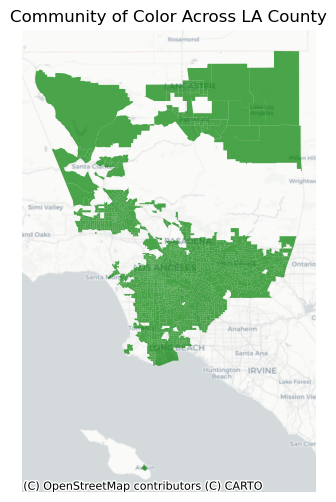

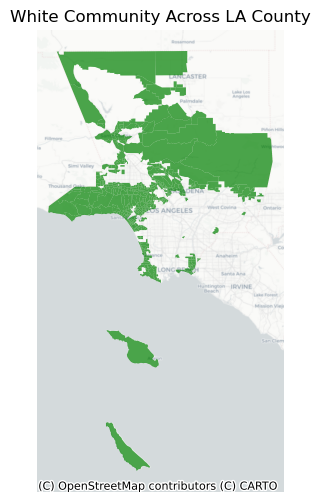

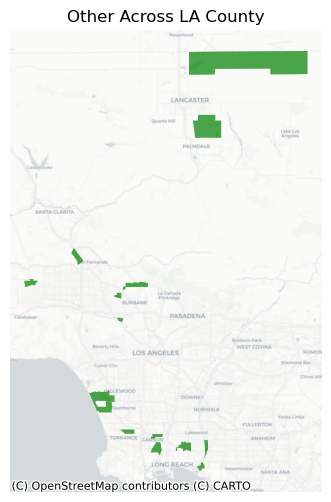

In [61]:
# isolating the neighborhood categories

la_neighborhoods = ['Community of Color', 'White Community', 'Other']

# creating a loop

for category in la_neighborhoods:
    make_maps(category)